In [1]:
import joblib
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

# BUFFER_SIZE = 60000
BATCH_SIZE = 256

EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 50

log_path = 'Log'
log_prefix = 'c_BEGAN_clipkt'


save_name = f'{log_prefix}_Cifar10_ckpt'
checkpoint_dir = './weight/'+save_name

lambda_v = 0.001
gamma = .5

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BATCH_SIZE).batch(BATCH_SIZE)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
image_prefix = os.path.join('.','image',save_name)

os.makedirs(log_path,exist_ok=True)

In [4]:
def make_generator_model():
    latent_inputs = tf.keras.Input((100,))
    conditional_inputs = tf.keras.Input((1,))
    
    linear_output = layers.Dense(8*8*256, use_bias=False)(latent_inputs)
    embed_output = layers.Embedding(10,8*8*256)(conditional_inputs)
    
    latent_vector = layers.multiply([embed_output, linear_output])
    batch = layers.BatchNormalization()(latent_vector)
    activ = layers.LeakyReLU()(batch)
    
    reshape = layers.Reshape((8,8,256))(activ)
    
    conv2dt = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
    batch = layers.BatchNormalization()(conv2dt)
    activ = layers.LeakyReLU()(batch)
    
    conv2dt = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(activ)
    batch = layers.BatchNormalization()(conv2dt)
    activ = layers.LeakyReLU()(batch)
    
    reconstruct_x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = 'tanh')(activ)

    return tf.keras.models.Model([latent_inputs,conditional_inputs],reconstruct_x)
    
    
    
def make_discriminator_model():
    
    inputs = tf.keras.Input((32, 32, 3))
    conditional_inputs = tf.keras.Input((1,))
    
    conv2d = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    embed_output = layers.Embedding(10,16*16)(conditional_inputs)
    
    latent = layers.multiply([conv2d,tf.reshape(embed_output,(-1,16,16,1))])
    activ = layers.LeakyReLU()(latent)
    drop = layers.Dropout(0.3)(activ)
    
    conv2d = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(drop)
    activ = layers.LeakyReLU()(conv2d)
    drop = layers.Dropout(0.3)(activ)
    
    flat = layers.Flatten()(drop)
    latent = layers.Dense(100,use_bias = False)(flat)
    activ = layers.LeakyReLU()(latent)
    drop = layers.Dropout(0.3)(activ)

    linear_output = layers.Dense(8*8*256, use_bias=False)(drop)
    batch = layers.BatchNormalization()(linear_output)
    activ = layers.LeakyReLU()(batch)
    
    reshape = layers.Reshape((8,8,256))(activ)
    
    conv2dt = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
    batch = layers.BatchNormalization()(conv2dt)
    activ = layers.LeakyReLU()(batch)
    
    conv2dt = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(activ)
    batch = layers.BatchNormalization()(conv2dt)
    activ = layers.LeakyReLU()(batch)
    
    reconstruct_x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = 'tanh')(activ)

    
    
    return tf.keras.models.Model([inputs,conditional_inputs],reconstruct_x)
    

In [5]:
# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.losses.mean_squared_error(tf.ones_like(real_output), real_output)
#     fake_loss = tf.losses.mean_squared_error(-1 * tf.ones_like(fake_output), fake_output)
#     total_loss = ( real_loss + fake_loss ) / 2
#     return total_loss

# def generator_loss(fake_output):
#     return tf.losses.mean_squared_error(tf.zeros_like(fake_output), fake_output) / 2
def began_loss(inputs,outputs):
    return tf.reduce_mean(tf.abs(inputs - outputs),[1,2,3])

@tf.function
def train_step(images,labels,k_t):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, \
    tf.GradientTape() as disc_tape:
        generated_images = generator((noise,labels), training=True)

        real_output = discriminator((images,labels), training=True)
        fake_output = discriminator((generated_images,labels), training=True)
        
        real_diff = began_loss(real_output, images)
        gen_diff = began_loss(fake_output, generated_images)
        
        disc_loss = real_diff - k_t * gen_diff
        gen_loss = gen_diff
        
        k_t += tf.reduce_mean(lambda_v * ( gamma * real_diff - gen_diff ))

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    return tf.clip_by_value(k_t,0,1)

def train(dataset, epochs, save_term = 50):
    k_t = 0
    for epoch in range(epochs):
        start = time.time()

        for image_batch,label_batch in dataset:
            k_t = train_step(image_batch,label_batch,k_t)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        if (epoch + 1) % save_term == 0:
            generator.save_weights(
                    os.path.join(
                    checkpoint_dir, f'epoch-{epoch + 1}'
                )
            )
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 5, i+1)
      plt.imshow((predictions[i, :, :, :] + 1 ) / 2)
      plt.axis('off')

  os.makedirs(image_prefix,exist_ok=True)
  plt.savefig(os.path.join(image_prefix,'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

In [6]:
k_t = 0

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# checkpoint = tf.train.Checkpoint(
#     generator_optimizer=generator_optimizer,
#     discriminator_optimizer=discriminator_optimizer,
#     generator=generator,
#     discriminator=discriminator
# )

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

seed = tf.random.normal([num_examples_to_generate, noise_dim],seed = 1234),\
tf.convert_to_tensor([[i//5] for i in range(num_examples_to_generate)],dtype = tf.int64)

%%time
train(train_dataset, EPOCHS)

plot_seed = tf.random.normal([num_examples_to_generate, noise_dim],seed = 1234),\
tf.convert_to_tensor([[i//5] for i in range(num_examples_to_generate)],dtype = tf.int64)
joblib.dump(plot_seed,'fixed_conditional_seed.joblib')

In [8]:
generator.load_weights(os.path.join(
                    checkpoint_dir, f'epoch-1000'
                ))

predictions = generator(joblib.load('fixed_conditional_seed.joblib'), training=False)

In [9]:
y_str = ['airplane'    ,
'automobile'  ,
'bird'        ,
'cat'         ,
'deer'        ,
'dog'         ,
'frog'        ,
'horse'       ,
'ship'        ,
'truck'       ,]

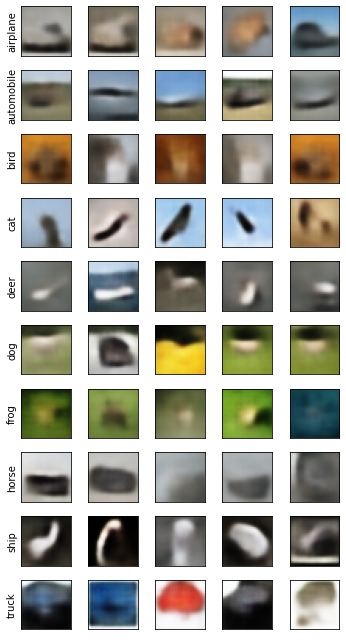

In [10]:
fig = plt.figure(figsize=(5,9))

for i in range(predictions.shape[0]):
    plt.subplot(10, 5, i+1)
    plt.imshow((predictions[i, :, :, :] + 1 ) / 2)
    if i%5 == 0:
#         print('ylabels')
        plt.ylabel(y_str[i//5])
    plt.xticks([]) ; plt.yticks([])
#     plt.axis('off')
fig.tight_layout()
joblib.dump(predictions.numpy(),os.path.join(log_path,f'{log_prefix}_numpy.joblib'))
fig.savefig(os.path.join(log_path,f'{log_prefix}_image.eps'),format = 'eps')